# Top-K Decoder for Y.Nakama's notebook.

The original top-k decoder is taken from https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/TopKDecoder.py and fixed the batch beam inference.

**Update**: with fast inferencing, now it should be 35% faster than previous.





# About this notebook
- PyTorch Resnet + LSTM with attention starter code
- Preprocess notebook is [here](https://www.kaggle.com/yasufuminakama/inchi-preprocess-2)
- Training notebook is [here](https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter)
- In this notebook, I use 2 epoch trained weight
- There is much room to improve, for example more epochs, augmentation, larger models, larger size...

If this notebook is helpful, feel free to upvote :)

# References
- https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning
- https://github.com/dacon-ai/LG_SMILES_3rd
- https://www.kaggle.com/kaushal2896/bms-mt-show-attend-and-tell-pytorch-baseline
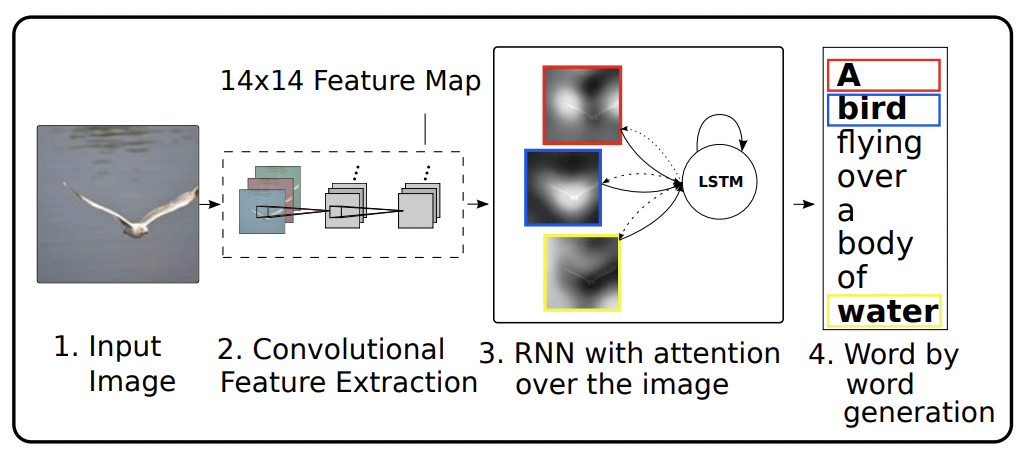
(Figure from https://arxiv.org/pdf/1502.03044.pdf)

# Data Loading

In [1]:
import numpy as np
import pandas as pd
import torch

# images ids are already sorted by inchi length from a previous submission
test = pd.read_csv('../input/inchiresnetlstmwithattentionstarter10epochs/sample_submission_with_length.csv')
# test = test.sort_values(by=['InChI_length'])
test = test.drop(columns=['InChI_length'])

def get_test_file_path(image_id):
    return "../input/bms-molecular-translation/test/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

test['file_path'] = test['image_id'].apply(get_test_file_path)

print(f'test.shape: {test.shape}')
display(test.head())

test.shape: (1616107, 3)


,image_id,InChI,file_path
0,e5dca4c9bebd,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/e/5/d/...
1,c2d86f19e139,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/c/2/d/...
2,2f939a72af1e,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/2/f/9/...
3,d92f14b46849,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/d/9/2/...
4,e5b5c145b588,InChI=1S/H2O/h1H2,../input/bms-molecular-translation/test/e/5/b/...


In [2]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('../input/inchi-preprocess-2/tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    max_len=275
    print_freq=1000
    num_workers=4
    model_name='resnet34'
    size=224
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=1 # not to exceed 9h
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=4 # CosineAnnealingLR
    #T_0=4 # CosineAnnealingWarmRestarts
    encoder_lr=1e-4
    decoder_lr=4e-4
    min_lr=1e-6
    batch_size=256
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=5
    attention_dim=256
    embed_dim=256
    decoder_dim=512
    dropout=0.5
    seed=42
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True

In [4]:
if CFG.debug:
    test = test.head(1000)

# Library

In [5]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file='inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False # True

seed_torch(seed=CFG.seed)

# Dataset

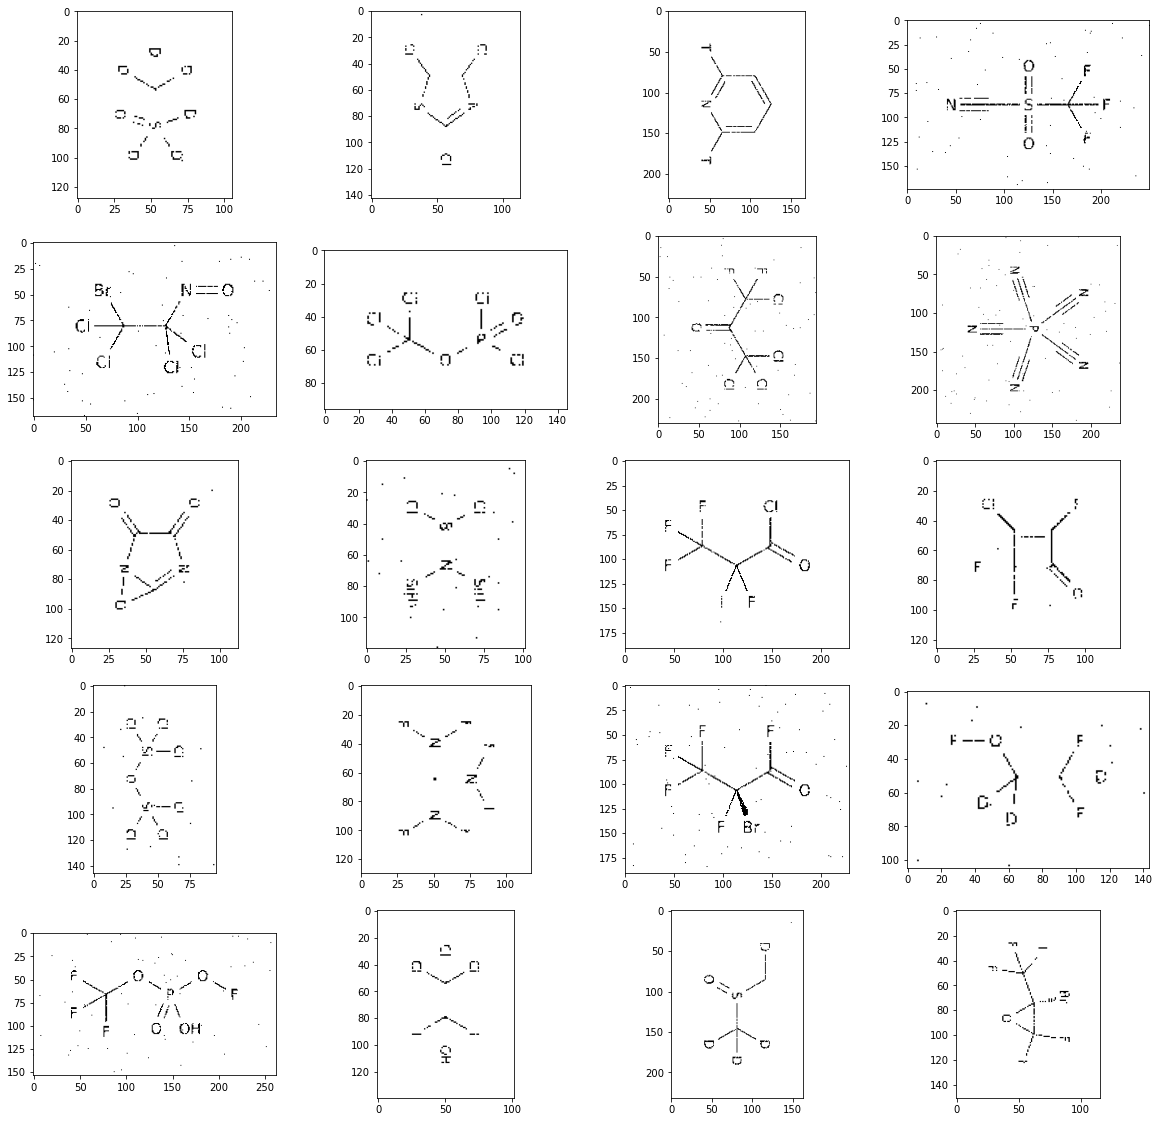

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

- There are 90° rotated images, but we trained horizontal compounds images, so we need to fix them

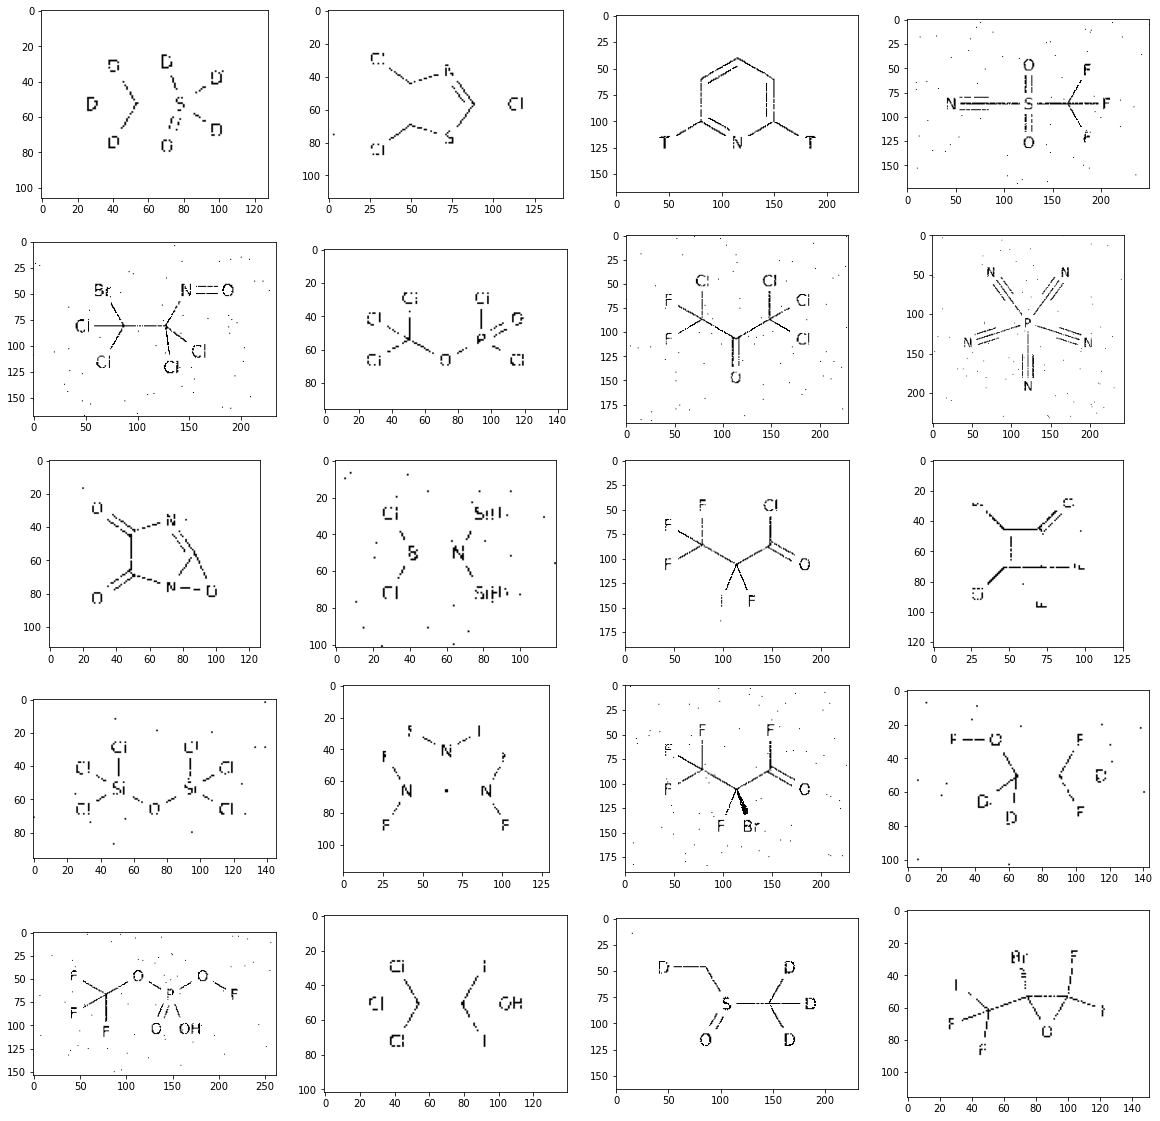

In [8]:
from matplotlib import pyplot as plt

transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    h, w, _ = image.shape
    if h > w:
        image = transform(image=image)['image']
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

In [9]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
        self.fix_transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image=image)['image']
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

# Transforms

In [10]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# Top-K Decoder

In [11]:
import torch
import torch.nn.functional as F


def _inflate(tensor, times, dim):
    # repeat_dims = [1] * tensor.dim()
    # repeat_dims[dim] = times
    # return tensor.repeat(*repeat_dims)
    return torch.repeat_interleave(tensor, times, dim)


class TopKDecoder(torch.nn.Module):
    r"""
    Top-K decoding with beam search.

    Args:
        decoder_rnn (DecoderRNN): An object of DecoderRNN used for decoding.
        k (int): Size of the beam.

    Inputs: inputs, encoder_hidden, encoder_outputs, function, teacher_forcing_ratio
        - **inputs** (seq_len, batch, input_size): list of sequences, whose length is the batch size and within which
          each sequence is a list of token IDs.  It is used for teacher forcing when provided. (default is `None`)
        - **encoder_hidden** (num_layers * num_directions, batch_size, hidden_size): tensor containing the features
          in the hidden state `h` of encoder. Used as the initial hidden state of the decoder.
        - **encoder_outputs** (batch, seq_len, hidden_size): tensor with containing the outputs of the encoder.
          Used for attention mechanism (default is `None`).
        - **function** (torch.nn.Module): A function used to generate symbols from RNN hidden state
          (default is `torch.nn.functional.log_softmax`).
        - **teacher_forcing_ratio** (float): The probability that teacher forcing will be used. A random number is
          drawn uniformly from 0-1 for every decoding token, and if the sample is smaller than the given value,
          teacher forcing would be used (default is 0).

    Outputs: decoder_outputs, decoder_hidden, ret_dict
        - **decoder_outputs** (batch): batch-length list of tensors with size (max_length, hidden_size) containing the
          outputs of the decoder.
        - **decoder_hidden** (num_layers * num_directions, batch, hidden_size): tensor containing the last hidden
          state of the decoder.
        - **ret_dict**: dictionary containing additional information as follows {*length* : list of integers
          representing lengths of output sequences, *topk_length*: list of integers representing lengths of beam search
          sequences, *sequence* : list of sequences, where each sequence is a list of predicted token IDs,
          *topk_sequence* : list of beam search sequences, each beam is a list of token IDs, *inputs* : target
          outputs if provided for decoding}.
    """

    def __init__(self, decoder_rnn, k, decoder_dim, max_length, tokenizer):
        super(TopKDecoder, self).__init__()
        self.rnn = decoder_rnn
        self.k = k
        self.hidden_size = decoder_dim  # self.rnn.hidden_size
        self.V = len(tokenizer)
        self.SOS = tokenizer.stoi["<sos>"]
        self.EOS = tokenizer.stoi["<eos>"]
        self.max_length = max_length
        self.tokenizer = tokenizer

    def forward(self, inputs=None, encoder_hidden=None, encoder_outputs=None, function=F.log_softmax,
                teacher_forcing_ratio=0, retain_output_probs=True):
        """
        Forward rnn for MAX_LENGTH steps.  Look at :func:`seq2seq.models.DecoderRNN.DecoderRNN.forward_rnn` for details.
        """

        # inputs, batch_size, max_length = self.rnn._validate_args(inputs, encoder_hidden, encoder_outputs,
        #                                                         function, teacher_forcing_ratio)

        batch_size = encoder_outputs.size(0)
        max_length = self.max_length

        self.pos_index = (torch.LongTensor(range(batch_size)) * self.k).view(-1, 1).cuda()

        # Inflate the initial hidden states to be of size: b*k x h
        # encoder_hidden = self.rnn._init_state(encoder_hidden)
        if encoder_hidden is None:
            hidden = None
        else:
            if isinstance(encoder_hidden, tuple):
                # hidden = tuple([_inflate(h, self.k, 1) for h in encoder_hidden])
                hidden = tuple([h.squeeze(0) for h in encoder_hidden])
                hidden = tuple([_inflate(h, self.k, 0) for h in hidden])
                hidden = tuple([h.unsqueeze(0) for h in hidden])
            else:
                # hidden = _inflate(encoder_hidden, self.k, 1)
                raise RuntimeError("Not supported")

        # ... same idea for encoder_outputs and decoder_outputs
        if True:  # self.rnn.use_attention:
            inflated_encoder_outputs = _inflate(encoder_outputs, self.k, 0)
        else:
            inflated_encoder_outputs = None

        # Initialize the scores; for the first step,
        # ignore the inflated copies to avoid duplicate entries in the top k
        sequence_scores = torch.Tensor(batch_size * self.k, 1)
        sequence_scores.fill_(-float('Inf'))
        sequence_scores.index_fill_(0, torch.LongTensor([i * self.k for i in range(0, batch_size)]), 0.0)
        sequence_scores = sequence_scores.cuda()

        # Initialize the input vector
        input_var = torch.transpose(torch.LongTensor([[self.SOS] * batch_size * self.k]), 0, 1).cuda()

        # Store decisions for backtracking
        stored_outputs = list()
        stored_scores = list()
        stored_predecessors = list()
        stored_emitted_symbols = list()
        stored_hidden = list()

        for i in range(0, max_length):

            # Run the RNN one step forward
            log_softmax_output, hidden, _ = self.rnn.forward_step(input_var, hidden,
                                                                  inflated_encoder_outputs, function=function)
            # If doing local backprop (e.g. supervised training), retain the output layer
            if retain_output_probs:
                stored_outputs.append(log_softmax_output)

            # To get the full sequence scores for the new candidates, add the local scores for t_i to the predecessor scores for t_(i-1)
            sequence_scores = _inflate(sequence_scores, self.V, 1)
            sequence_scores += log_softmax_output.squeeze(1)
            scores, candidates = sequence_scores.view(batch_size, -1).topk(self.k, dim=1)

            # Reshape input = (bk, 1) and sequence_scores = (bk, 1)
            input_var = (candidates % self.V).view(batch_size * self.k, 1)
            sequence_scores = scores.view(batch_size * self.k, 1)

            # Update fields for next timestep
            predecessors = (candidates // self.V + self.pos_index.expand_as(candidates)).view(batch_size * self.k, 1)
            if isinstance(hidden, tuple):
                hidden = tuple([h.index_select(1, predecessors.squeeze()) for h in hidden])
            else:
                hidden = hidden.index_select(1, predecessors.squeeze())

            # Update sequence scores and erase scores for end-of-sentence symbol so that they aren't expanded
            stored_scores.append(sequence_scores.clone())
            eos_indices = input_var.data.eq(self.EOS)
            if eos_indices.nonzero().dim() > 0:
                sequence_scores.data.masked_fill_(eos_indices, -float('inf'))

            # Cache results for backtracking
            stored_predecessors.append(predecessors)
            stored_emitted_symbols.append(input_var)
            stored_hidden.append(hidden)

        # Do backtracking to return the optimal values
        output, h_t, h_n, s, l, p = self._backtrack(stored_outputs, stored_hidden,
                                                    stored_predecessors, stored_emitted_symbols,
                                                    stored_scores, batch_size, self.hidden_size)

        # Build return objects
        decoder_outputs = [step[:, 0, :] for step in output]
        if isinstance(h_n, tuple):
            decoder_hidden = tuple([h[:, :, 0, :] for h in h_n])
        else:
            decoder_hidden = h_n[:, :, 0, :]
        metadata = {}
        metadata['inputs'] = inputs
        metadata['output'] = output
        metadata['h_t'] = h_t
        metadata['score'] = s
        metadata['topk_length'] = l
        metadata['topk_sequence'] = p
        metadata['length'] = [seq_len[0] for seq_len in l]
        metadata['sequence'] = [seq[0] for seq in p]
        return decoder_outputs, decoder_hidden, metadata

    def _backtrack(self, nw_output, nw_hidden, predecessors, symbols, scores, b, hidden_size):
        """Backtracks over batch to generate optimal k-sequences.

        Args:
            nw_output [(batch*k, vocab_size)] * sequence_length: A Tensor of outputs from network
            nw_hidden [(num_layers, batch*k, hidden_size)] * sequence_length: A Tensor of hidden states from network
            predecessors [(batch*k)] * sequence_length: A Tensor of predecessors
            symbols [(batch*k)] * sequence_length: A Tensor of predicted tokens
            scores [(batch*k)] * sequence_length: A Tensor containing sequence scores for every token t = [0, ... , seq_len - 1]
            b: Size of the batch
            hidden_size: Size of the hidden state

        Returns:
            output [(batch, k, vocab_size)] * sequence_length: A list of the output probabilities (p_n)
            from the last layer of the RNN, for every n = [0, ... , seq_len - 1]

            h_t [(batch, k, hidden_size)] * sequence_length: A list containing the output features (h_n)
            from the last layer of the RNN, for every n = [0, ... , seq_len - 1]

            h_n(batch, k, hidden_size): A Tensor containing the last hidden state for all top-k sequences.

            score [batch, k]: A list containing the final scores for all top-k sequences

            length [batch, k]: A list specifying the length of each sequence in the top-k candidates

            p (batch, k, sequence_len): A Tensor containing predicted sequence
        """

        lstm = isinstance(nw_hidden[0], tuple)

        # initialize return variables given different types
        output = list()
        h_t = list()
        p = list()
        # Placeholder for last hidden state of top-k sequences.
        # If a (top-k) sequence ends early in decoding, `h_n` contains
        # its hidden state when it sees EOS.  Otherwise, `h_n` contains
        # the last hidden state of decoding.
        if lstm:
            state_size = nw_hidden[0][0].size()
            h_n = tuple([torch.zeros(state_size).cuda(), torch.zeros(state_size).cuda()])
        else:
            h_n = torch.zeros(nw_hidden[0].size()).cuda()
        l = [[self.max_length] * self.k for _ in range(b)]  # Placeholder for lengths of top-k sequences
        # Similar to `h_n`

        # the last step output of the beams are not sorted
        # thus they are sorted here
        sorted_score, sorted_idx = scores[-1].view(b, self.k).topk(self.k)
        # initialize the sequence scores with the sorted last step beam scores
        s = sorted_score.clone()

        batch_eos_found = [0] * b  # the number of EOS found
        # in the backward loop below for each batch

        t = self.max_length - 1
        # initialize the back pointer with the sorted order of the last step beams.
        # add self.pos_index for indexing variable with b*k as the first dimension.
        t_predecessors = (sorted_idx + self.pos_index.expand_as(sorted_idx)).view(b * self.k)
        while t >= 0:
            # Re-order the variables with the back pointer
            current_output = nw_output[t].index_select(0, t_predecessors)
            if lstm:
                current_hidden = tuple([h.index_select(1, t_predecessors) for h in nw_hidden[t]])
            else:
                current_hidden = nw_hidden[t].index_select(1, t_predecessors)
            current_symbol = symbols[t].index_select(0, t_predecessors)
            # Re-order the back pointer of the previous step with the back pointer of
            # the current step
            t_predecessors = predecessors[t].index_select(0, t_predecessors).squeeze()

            # This tricky block handles dropped sequences that see EOS earlier.
            # The basic idea is summarized below:
            #
            #   Terms:
            #       Ended sequences = sequences that see EOS early and dropped
            #       Survived sequences = sequences in the last step of the beams
            #
            #       Although the ended sequences are dropped during decoding,
            #   their generated symbols and complete backtracking information are still
            #   in the backtracking variables.
            #   For each batch, everytime we see an EOS in the backtracking process,
            #       1. If there is survived sequences in the return variables, replace
            #       the one with the lowest survived sequence score with the new ended
            #       sequences
            #       2. Otherwise, replace the ended sequence with the lowest sequence
            #       score with the new ended sequence
            #
            eos_indices = symbols[t].data.squeeze(1).eq(self.EOS).nonzero()
            if eos_indices.dim() > 0:
                for i in range(eos_indices.size(0) - 1, -1, -1):
                    # Indices of the EOS symbol for both variables
                    # with b*k as the first dimension, and b, k for
                    # the first two dimensions
                    idx = eos_indices[i]
                    b_idx = int(idx[0] // self.k)
                    # The indices of the replacing position
                    # according to the replacement strategy noted above
                    res_k_idx = self.k - (batch_eos_found[b_idx] % self.k) - 1
                    batch_eos_found[b_idx] += 1
                    res_idx = b_idx * self.k + res_k_idx

                    # Replace the old information in return variables
                    # with the new ended sequence information
                    t_predecessors[res_idx] = predecessors[t][idx[0]]
                    current_output[res_idx, :] = nw_output[t][idx[0], :]
                    if lstm:
                        current_hidden[0][:, res_idx, :] = nw_hidden[t][0][:, idx[0], :]
                        current_hidden[1][:, res_idx, :] = nw_hidden[t][1][:, idx[0], :]
                        h_n[0][:, res_idx, :] = nw_hidden[t][0][:, idx[0], :].data
                        h_n[1][:, res_idx, :] = nw_hidden[t][1][:, idx[0], :].data
                    else:
                        current_hidden[:, res_idx, :] = nw_hidden[t][:, idx[0], :]
                        h_n[:, res_idx, :] = nw_hidden[t][:, idx[0], :].data
                    current_symbol[res_idx, :] = symbols[t][idx[0]]
                    s[b_idx, res_k_idx] = scores[t][idx[0]].data[0]
                    l[b_idx][res_k_idx] = t + 1

            # record the back tracked results
            output.append(current_output)
            h_t.append(current_hidden)
            p.append(current_symbol)

            t -= 1

        # Sort and re-order again as the added ended sequences may change
        # the order (very unlikely)
        s, re_sorted_idx = s.topk(self.k)
        for b_idx in range(b):
            l[b_idx] = [l[b_idx][k_idx.item()] for k_idx in re_sorted_idx[b_idx, :]]

        re_sorted_idx = (re_sorted_idx + self.pos_index.expand_as(re_sorted_idx)).view(b * self.k)

        # Reverse the sequences and re-order at the same time
        # It is reversed because the backtracking happens in reverse time order
        output = [step.index_select(0, re_sorted_idx).view(b, self.k, -1) for step in reversed(output)]
        p = [step.index_select(0, re_sorted_idx).view(b, self.k, -1) for step in reversed(p)]
        if lstm:
            h_t = [tuple([h.index_select(1, re_sorted_idx).view(-1, b, self.k, hidden_size) for h in step]) for step in reversed(h_t)]
            h_n = tuple([h.index_select(1, re_sorted_idx.data).view(-1, b, self.k, hidden_size) for h in h_n])
        else:
            h_t = [step.index_select(1, re_sorted_idx).view(-1, b, self.k, hidden_size) for step in reversed(h_t)]
            h_n = h_n.index_select(1, re_sorted_idx.data).view(-1, b, self.k, hidden_size)
        s = s.data

        return output, h_t, h_n, s, l, p

    def _mask_symbol_scores(self, score, idx, masking_score=-float('inf')):
        score[idx] = masking_score

    def _mask(self, tensor, idx, dim=0, masking_score=-float('inf')):
        if len(idx.size()) > 0:
            indices = idx[:, 0]
            tensor.index_fill_(dim, indices, masking_score)

# MODEL

In [12]:
class Encoder(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained=pretrained)
        self.n_features = self.cnn.fc.in_features
        self.cnn.global_pool = nn.Identity()
        self.cnn.fc = nn.Identity()

    def forward(self, x):
        bs = x.size(0)
        features = self.cnn(x)
        features = features.permute(0, 2, 3, 1)
        return features

In [13]:
class Attention(nn.Module):
    """
    Attention network for calculate attention value
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder network with attention network used for training
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim=512, dropout=0.5):
        """
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param dropout: dropout rate
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype=torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        embeddings = self.embedding(start_tockens)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(self.device)
        end_condition = torch.zeros(batch_size, dtype=torch.long).to(encoder_out.device)
        # predict sequence
        for t in range(decode_lengths):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1),
                (h, c))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions
    
    def forward_step(self, prev_tokens, hidden, encoder_out, function):
        assert len(hidden) == 2
        h, c = hidden
        h, c = h.squeeze(0), c.squeeze(0)

        embeddings = self.embedding(prev_tokens)
        if embeddings.dim() == 3:
            embeddings = embeddings.squeeze(1)

        attention_weighted_encoding, alpha = self.attention(encoder_out, h)
        gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding
        h, c = self.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1),
            (h, c))  # (batch_size_t, decoder_dim)
        preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)

        hidden = (h.unsqueeze(0), c.unsqueeze(0))
        predicted_softmax = function(preds, dim=1)
        return predicted_softmax, hidden, None

# Inference

In [14]:
def inference(test_loader, encoder, decoder, tokenizer, device):
    encoder.eval()
    decoder.eval()
    text_preds = []
    
    # k = 2
    topk_decoder = TopKDecoder(decoder, 2, CFG.decoder_dim, CFG.max_len, tokenizer)
    
    tk0 = tqdm(test_loader, total=len(test_loader))
    for images in tk0:
        images = images.to(device)
        predictions = []
        with torch.no_grad():
            encoder_out = encoder(images)
            batch_size = encoder_out.size(0)
            encoder_dim = encoder_out.size(-1)
            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
            h, c = decoder.init_hidden_state(encoder_out)
            hidden = (h.unsqueeze(0), c.unsqueeze(0))
            
            decoder_outputs, decoder_hidden, other = topk_decoder(None, hidden, encoder_out)
            
            for b in range(batch_size):
                length = other['topk_length'][b][0]
                tgt_id_seq = [other['topk_sequence'][di][b, 0, 0].item() for di in range(length)]
                predictions.append(tgt_id_seq)
            assert len(predictions) == batch_size
            
        predictions = tokenizer.predict_captions(predictions)
        predictions = ['InChI=1S/' + p.replace('<sos>', '') for p in predictions]
        # print(predictions[0])
        text_preds.append(predictions)
    text_preds = np.concatenate(text_preds)
    return text_preds

In [15]:
states = torch.load(f'../input/inchiresnetlstmwithattentionstarter10epochs/resnet34-fold0-10epochs.pth', map_location=torch.device('cpu'))

encoder = Encoder(CFG.model_name, pretrained=False)
encoder.load_state_dict(states['encoder'])
encoder.to(device)

decoder = DecoderWithAttention(attention_dim=CFG.attention_dim,
                               embed_dim=CFG.embed_dim,
                               decoder_dim=CFG.decoder_dim,
                               vocab_size=len(tokenizer),
                               dropout=CFG.dropout,
                               device=device)
decoder.load_state_dict(states['decoder'])
decoder.to(device)

del states; gc.collect()

test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=CFG.num_workers)
predictions = inference(test_loader, encoder, decoder, tokenizer, device)

del test_loader, encoder, decoder, tokenizer; gc.collect()

  0%|          | 0/6313 [00:00<?, ?it/s]

0

In [16]:
# submission
test['InChI'] = [f"{text}" for text in predictions]
test[['image_id', 'InChI']].to_csv('submission.csv', index=False)
test[['image_id', 'InChI']].head()

,image_id,InChI
0,e5dca4c9bebd,"InChI=1S/CH4Cl2O2/c3-8(4,5)1-2/h3H2"
1,c2d86f19e139,"InChI=1S/C3HCl3NS/c4-1-2(5)8-3(6)9-1/h1,7+"
2,2f939a72af1e,InChI=1S/C5H4IN/c6-5-3-1-2-4-7-5/h1-4H
3,d92f14b46849,"InChI=1S/C2F4O2S/c3-2(4,5)9(6,7)1-8"
4,e5b5c145b588,"InChI=1S/C2Cl5O2/c3-1(4,5)2(6,7)8-9"
